# Location of Geomagetic Poles

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from pathlib import Path
import pandas as pd
import collections
from scipy.stats import binned_statistic_2d
from functions import *
import os
import sys

In [2]:
output_folder = Path.cwd()/"output_plots"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Import and read dataframe and geomagnetic pole location files

In [8]:
dataframe_file = "pkl_files/data_2020_10_19_to_2024_10_26.pkl"
data_file = Path(dataframe_file)

all_data = pd.read_pickle(data_file)
all_data['year'] = all_data['time'].dt.year

pole_data= pd.read_csv(Path("pole_data.txt"), delimiter=' ')

year_data = all_data['year']
year_poles = pole_data['year']

# Definde plot function

In [4]:
def plot_function(data_to_plot, title):
    
    def plotimg(idx):
        # Update histogram
        ax[0].clear()
        ax[0].hist(data_to_plot[int(idx)].flatten(), bins = len(np.unique(data_to_plot[int(idx)].flatten())))
        # Update image
        img.set_data(data_to_plot[int(idx),:,:])
        im = ax[1].imshow(data_to_plot[int(idx),:,:], origin='lower', cmap = 'viridis')
        ax[0].axvline(np.nanmedian(data_to_plot[int(idx),:,:]), c = 'r',  alpha = 0.5) # median pixel value
        ax[0].axvline(np.nanmean(data_to_plot[int(idx),:,:]), c = 'g', alpha = 0.5) # mean pixel value
        #plt.colorbar(im)
        fig.canvas.draw_idle()
        
    fig, ax = plt.subplots(ncols = 2, figsize=(12,4))
    img = ax[1].imshow(data_to_plot[0], origin='lower')
    #colorbar = plt.colorbar(img)
    ax[0].set_xlabel('Brightness')
    ax[0].set_ylabel('Nb of pixels')
    plt.suptitle(title, weight = 'bold')

    ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=np.shape(data_to_plot)[0]-1,step=1))
    plt.show()
    
def apply_filters(data, filter_names, values, reverse_filters):
    
    # Available filters ['latitude-','latitude+','visit','density_cosmics','nb_cosmics','no_straylight','largest_cosmics']
    list_filter_names = ['time-','time+','latitude-','latitude+','visit','density_cosmics','nb_cosmics','no_straylight','largest_cosmics']
    
    filtered_data = data.copy()
    
    for filter_name, value, reverse in zip(filter_names,values, reverse_filters): 
        
        if reverse:
            inf = '>'
            sup = '<'
        else: 
            inf = '<'
            sup = '>'
            
        if filter_name == 'time-':
            print(f"Keep data {sup} {value}")
            filter_to_apply = filtered_data['time'] >= value
        elif filter_name == 'time+':
            print(f"Keep data {inf} {value}")
            filter_to_apply = filtered_data['time'] <= value
        elif filter_name == 'latitude-':
            print(f"Kepp data with latitude {sup} {value}")
            filter_to_apply = filtered_data['LATITUDE'] > value
        elif filter_name == 'latitude+':
            print(f"Keep with latitude {inf} {value}")
            filter_to_apply = filtered_data['LATITUDE'] < value  
        elif filter_name == 'visit':
            print(f"Keep data only from {value}")
            filter_to_apply = filtered_data['visit_ID'] == value
        elif filter_name == 'density_cosmics':
            print(f"Keep data only with a density of cosmics {sup} {value}")
            filter_to_apply = filtered_data['density_cosmics'] > value        
        elif filter_name == 'nb_cosmics':
            print(f"Keep data only with a number of cosmics {sup} {value}")
            filter_to_apply = filtered_data['nb_cosmics'] > value        
        elif filter_name == 'no_straylight':
            if reverse:
                print(f"Keep data only affected with straylight")
            else:
                print(f"Keep data only not affected with straylight")
            filter_to_apply = filtered_data['straylight_boolean']
            filter_to_apply = ~filter_to_apply
        elif filter_name == 'largest_cosmics':
            print(f"Keep data only with a largest cosmic {inf} {value}")
            filter_to_apply = filtered_data['largest_cosmics'] < value
        else:
            print(f"Filter_name not in {list_filter_names}")   
            
        # apply filter 
        if reverse:
            filter_to_apply = ~filter_to_apply

        nb_points = len(filtered_data)
        filtered_data = filtered_data[filter_to_apply]
        nb_datapoints_remomoved =  nb_points - len(filtered_data)
        print(f"Removed {nb_datapoints_remomoved} data points, kept {len(filtered_data)}")
        
    return filtered_data

# Detections

In [5]:
if len(np.unique(all_data['im_height'])) > 1:
    diff_image_types = True # We have different image sizes in all_data
    print(f"Sizes available are {np.unique(all_data['im_height'])}")
else:
    diff_image_types = False

# Filter images

In [6]:
# DETECTIONS 
detections = all_data[all_data['nb_cosmics'] != 0]
#detections = all_data[(all_data['density_cosmics'] < 60) & (all_data['density_cosmics'] > 40)]
non_detections = all_data[all_data['nb_cosmics'] == 0]

max_cosmics = np.max(detections['nb_cosmics'])
max_density = np.max(detections['density_cosmics'])

print(f'Frame with most cosmics has {max_cosmics} cosmics. largest density is {int(max_density)} hits/cm2/sec')
print(f"{int(len(detections)/len(all_data)*100)}% of visits ({len(detections)}/{len(all_data)}) have detections. {int(len(non_detections))} non detections\n")

# separate different images sizes
if diff_image_types:
    size_to_keep = 200
    detections_plot = detections[detections['im_height'] == size_to_keep]
    non_detections_plot = non_detections[non_detections['im_height'] == size_to_keep]
    print(f"!! Only images of sizes {size_to_keep}*{size_to_keep} are shown !!\n")
else:     
    detections_plot = detections
    non_detections_plot = non_detections
    
## Add other filters 
# Available filters ['latitude-','latitude+','visit','density_cosmics','nb_cosmics','no_straylight','largest_cosmics']
filters = ['no_straylight','largest_cosmics']
values = [None, 130]
reverse_filters = [False, False]

detections_plot = apply_filters(detections_plot,filters,values,reverse_filters)
print("")
non_detections_plot = apply_filters(non_detections_plot,filters,values,reverse_filters)

Frame with most cosmics has 670 cosmics. largest density is 470 hits/cm2/sec
60% of visits (11126/18449) have detections. 7323 non detections

Keep data only not affected with straylight
Removed 453 data points, kept 10673
Keep data only with a largest cosmic < 130
Removed 267 data points, kept 10406

Keep data only not affected with straylight
Removed 22 data points, kept 7301
Keep data only with a largest cosmic < 130
Removed 0 data points, kept 7301


# Mapping

In [7]:
import cartopy.crs as ccrs
import matplotlib
from matplotlib.colors import ListedColormap, LogNorm
import numpy as np

In [8]:
map_data = all_data.copy()

## APPLY FILTER TO DATA ##
# start_date = pd.Timestamp("2024-08-05 12:00:00", tz = 'UTC')
start_date = all_data.time.min()
#end_date = pd.Timestamp("2024-06-01 12:00:00", tz = 'UTC')
end_date = all_data.time.max()

# filters = ['time-','time+','no_straylight','largest_cosmics']
# values = [start_date, end_date, None, 100]
# reverse_filters = [False, False, False, False]
# map_data = apply_filters(map_data,filters,values,reverse_filters)

filters = ['no_straylight','largest_cosmics']
values = [None, 130]
reverse_filters = [False, False]
map_data = apply_filters(map_data,filters,values,reverse_filters)

nb_visits = len(np.unique(all_data.visit_ID))
nb_SAA_visits = len(np.unique(all_data[all_data.visit_ID.str[:6] == '34_102'].visit_ID))

print(f"\nVisits go from {start_date.strftime('%d-%b-%Y')} to {end_date.strftime('%d-%b-%Y')}")
print(f"There are {nb_visits} in total, including {nb_SAA_visits} SAA visits")

data_plot = map_data

Keep data only not affected with straylight
Removed 475 data points, kept 17974
Keep data only with a largest cosmic < 130
Removed 267 data points, kept 17707

Visits go from 19-Oct-2020 to 26-Oct-2024
There are 40 in total, including 0 SAA visits


In [9]:
# Read SAA mask
SAA_file = Path("ref_files") / "CH_TU2024-01-16T15-06-00_EXT_APP_SAAMap-690km_V0301.fits"

data_SAA = read_SAA_map(SAA_file)

# Bin and maks SAA mask contour
lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90

# Plot SAA mask
x = data_SAA['longitude']
y = data_SAA['latitude']
c = data_SAA['SAA_FLAG']

SAA_map_bins_lon = 4
SAA_map_bins_lat = 4
x_bins_SAA = np.arange(lon_min + SAA_map_bins_lon, lon_max,SAA_map_bins_lon)
y_bins_SAA = np.arange(lat_min + SAA_map_bins_lat, lat_max,SAA_map_bins_lat)

SAA_masked_binned = binned_statistic_2d(x, y, c, statistic='median', bins=[x_bins_SAA, y_bins_SAA]).statistic.T
lon, lat = np.meshgrid(x_bins_SAA, y_bins_SAA)

#cmap = ListedColormap(['none', 'white'])
#ax.imshow(ret_SAA.statistic.T, origin='lower', cmap = cmap, alpha = 0.7, extent=(lon_min, lon_max, lat_min, lat_max)) # Supported values for interplotation are 'none', 'antialiased', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'.


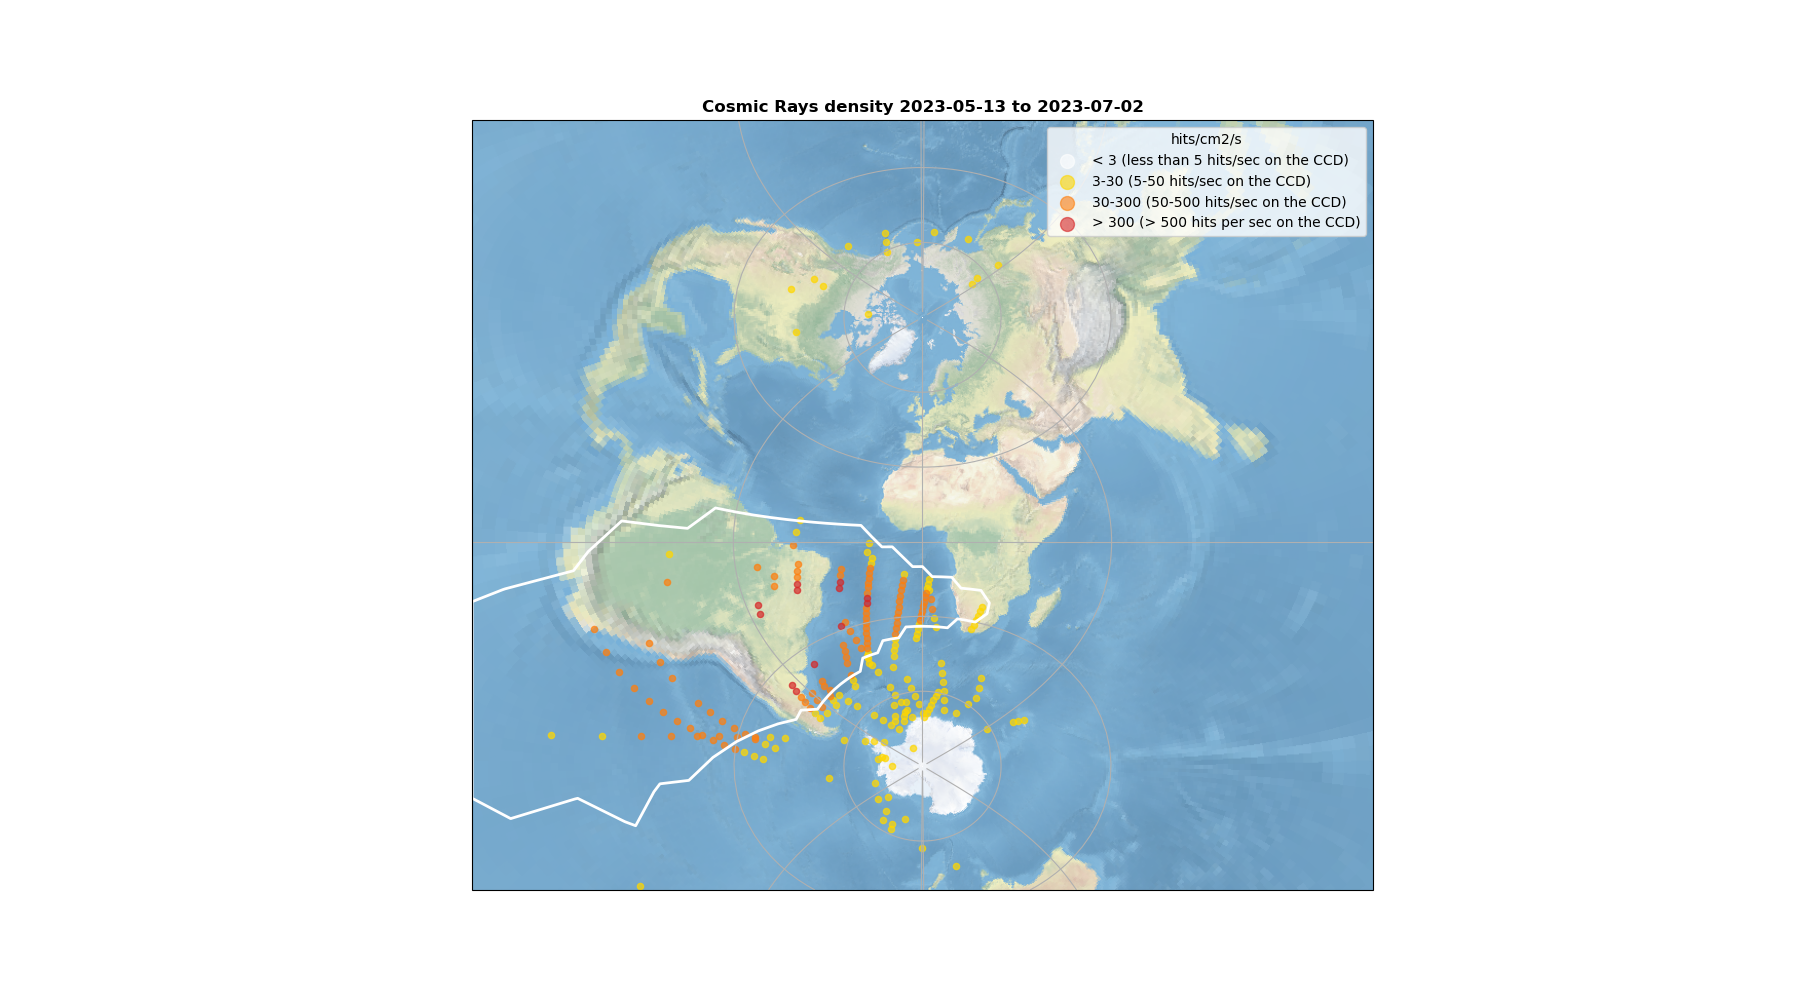

In [ ]:
%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=(18, 10))
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Orthographic(0, -90))
ax = plt.axes(projection=ccrs.ObliqueMercator())
ax.stock_img()
ax.gridlines()

plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())

labels = ['< 3 (less than 5 hits/sec on the CCD) ','3-30 (5-50 hits/sec on the CCD) ','30-300 (50-500 hits/sec on the CCD) ', '> 300 (> 500 hits per sec on the CCD)']
colors = ['white','gold','C1','C3']
cm = ListedColormap(colors)
for i in range(4):
    if i == 0:
        continue
        x = data_plot.loc[data_plot['density_cosmics'] < 3]['LONGITUDE']
        y = data_plot.loc[data_plot['density_cosmics'] < 3]['LATITUDE']
        alpha = 0.5
        
    if i == 1:
        x = data_plot.loc[(data_plot['density_cosmics'] > 3) & (data_plot['density_cosmics'] < 30)]['LONGITUDE']
        y = data_plot.loc[(data_plot['density_cosmics'] > 3) & (data_plot['density_cosmics'] < 30)]['LATITUDE']
        alpha = 0.7
        
    if i == 2:
        x = data_plot.loc[(data_plot['density_cosmics'] >= 30) & (data_plot['density_cosmics'] < 300)]['LONGITUDE']
        y = data_plot.loc[(data_plot['density_cosmics'] >= 30) & (data_plot['density_cosmics'] < 300)]['LATITUDE']
        alpha = 0.7
    
        
    if i == 3:
        x = data_plot.loc[data_plot['density_cosmics'] >= 300]['LONGITUDE']
        y = data_plot.loc[data_plot['density_cosmics'] >= 300]['LATITUDE']
        alpha = 0.7
    
    cr = plt.scatter(x,y,c = colors[i], s = 20, alpha = alpha, marker = 'o', transform=ccrs.Geodetic(), label = labels[i])


handles = [
    plt.scatter([], [], s=100, c=colors[0], alpha=0.6, label=labels[0]),
    plt.scatter([], [], s=100, c=colors[1], alpha=0.6, label=labels[1]),
    plt.scatter([], [], s=100, c=colors[2], alpha=0.6, label=labels[2]),
    plt.scatter([], [], s=100, c=colors[3], alpha=0.6, label=labels[3]),

]



# Add legend to the plot with custom background color
legend = plt.legend(handles=handles, title="hits/cm2/s")
legend.get_frame().set_facecolor('white')    

largest_cr = values[1]

title = 'Cosmic Rays density ' + data_plot.time.min().strftime('%Y-%m-%d') + ' to ' + data_plot.time.max().strftime('%Y-%m-%d')
plt.title(title, weight = 'bold')
fileout_name = "no_filters_CR_density_visits_discrete_" + data_plot.time.min().strftime('%Y-%m-%d') + "_to_" + data_plot.time.max().strftime('%Y-%m-%d')+ "_largest_CR_"+ str(largest_cr) +".png"
plt.savefig(output_folder / fileout_name, transparent = False, dpi = 600,format = 'png')

Text(0.5, 1.0, 'Cosmic Rays density 2023-05-13 to 2023-07-02')

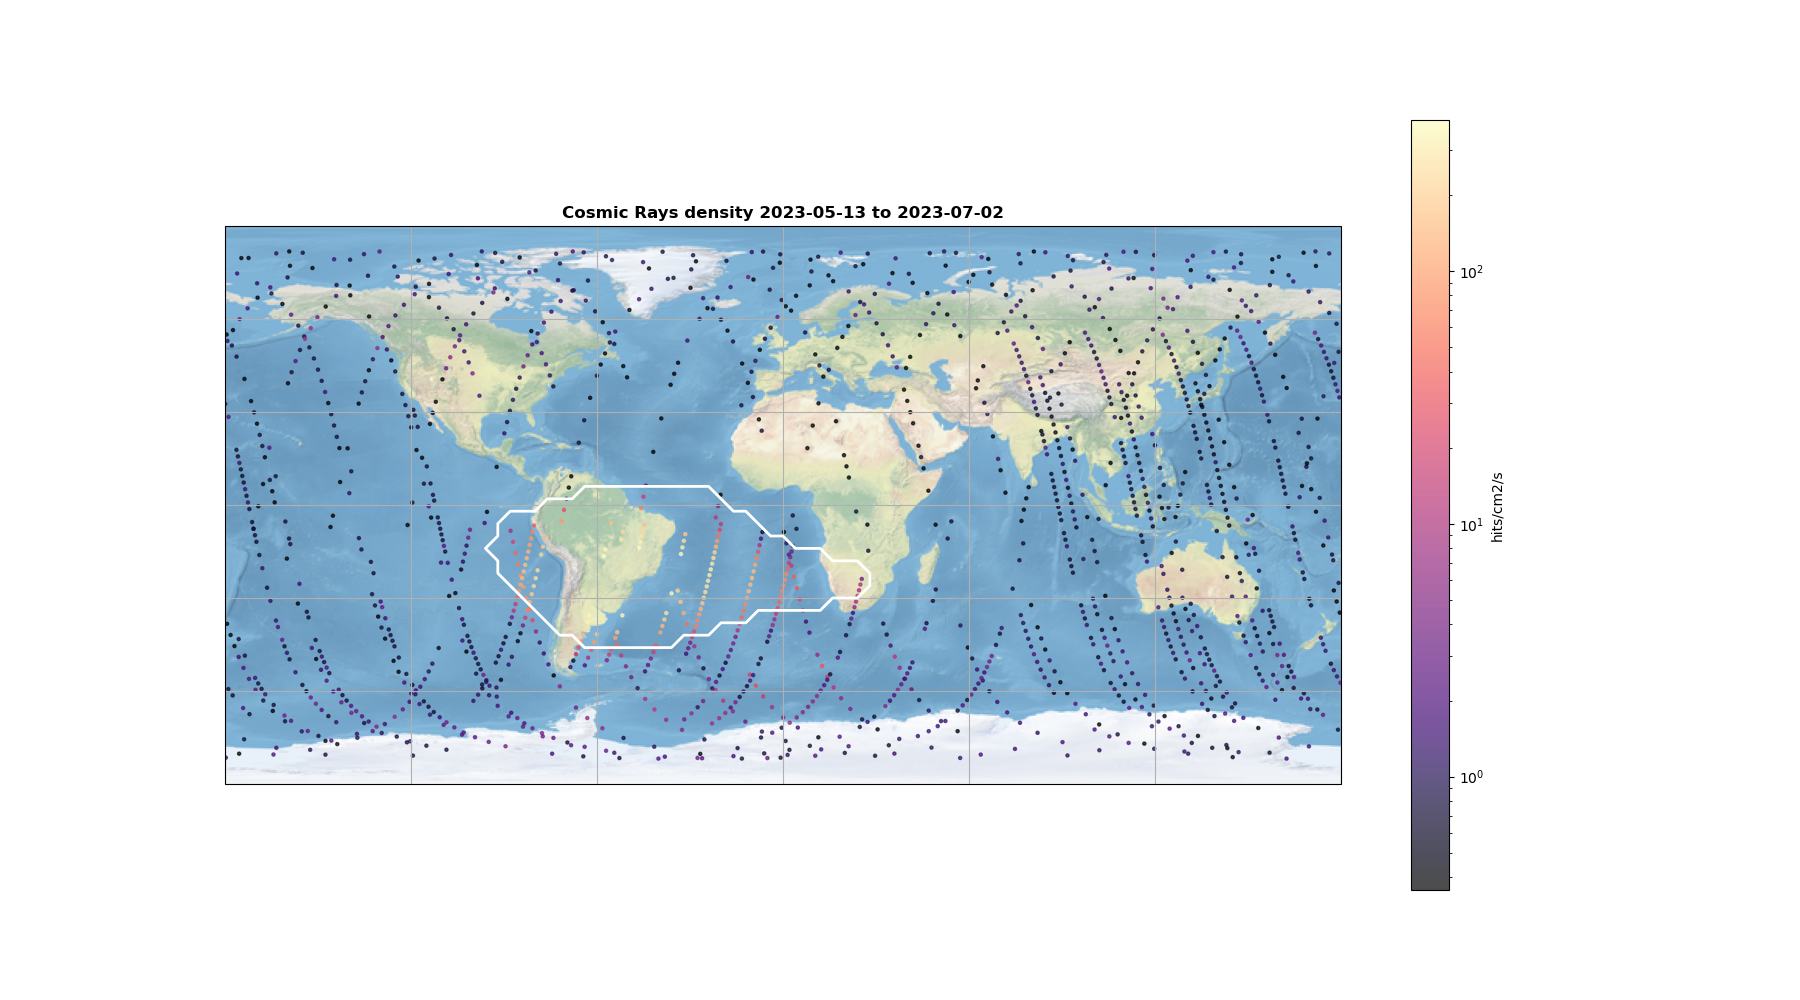

In [12]:
#%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=(18, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Orthographic(0, -90))
ax.stock_img()
ax.gridlines()

# Plot SAA contour
plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())

x = data_plot['LONGITUDE']
y = data_plot['LATITUDE']
c = data_plot['density_cosmics']

cr = plt.scatter(x,y,c = c, s = 5, norm=LogNorm(), alpha = 0.7, marker = 'o', cmap='magma', transform=ccrs.Geodetic())#, label = labels[i])
plt.colorbar(cr, label = 'hits/cm2/s' )

# #plt.title('June 28th, at 08:40:00, SAA_FLAG is False in MPS_PRE_VISIT')
# #plt.legend(frameon=True,bbox_to_anchor=(0.7,0),markerscale=1)
# #save_folder = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SSA_mismapping/imagette_mapping/AU_Mic_5_sec_visits/'
# name_addition = 'all'
# save_name = 'map_CR_detections_'+ name_addition + '_' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + '_to_' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d") + '.png'
#title = str(len(data_plot)) + ' detections from ' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + ' to ' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d")
title = 'Cosmic Rays density ' + data_plot.time.min().strftime('%Y-%m-%d') + ' to ' + data_plot.time.max().strftime('%Y-%m-%d')
plt.title(title, weight = 'bold')
#fileout_name = "CR_density_" + data_plot.time.min().strftime('%Y-%m-%d') + "_to_" + data_plot.time.max().strftime('%Y-%m-%d')+ ".png"
#plt.savefig(output_folder / fileout_name, transparent = False, dpi = 600,format = 'png')

interactive(children=(FloatSlider(value=0.0, description='idx', max=0.0, step=1.0), Output()), _dom_classes=('…

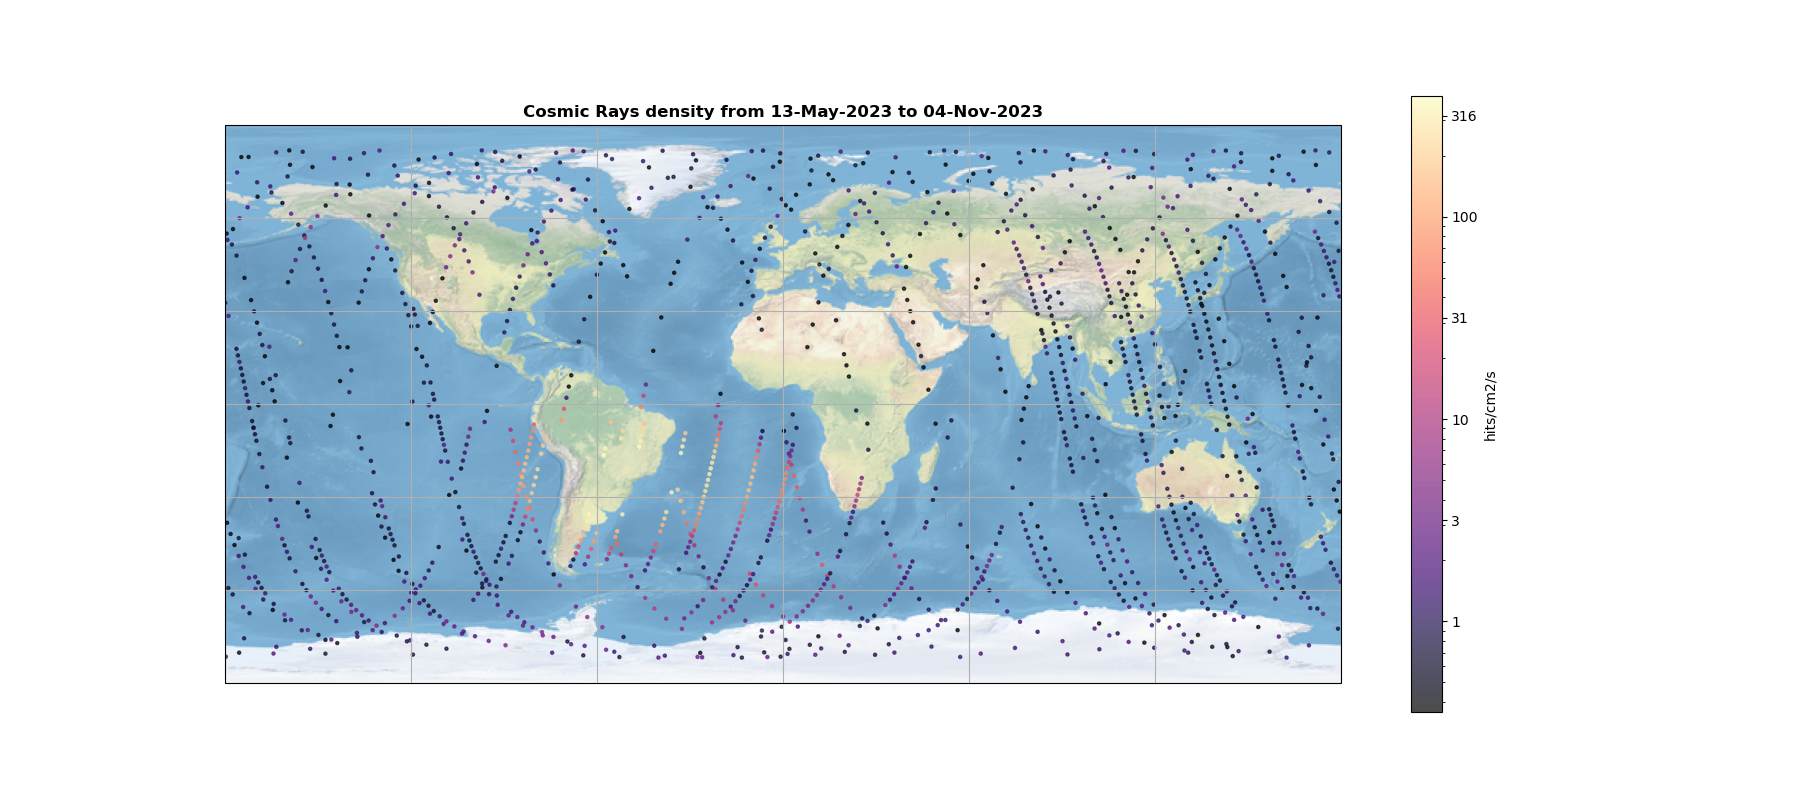

In [13]:
def update_data(idx):
    start = start_date + time_resolution*int(idx)
    end  = start_date + time_resolution*(int(idx)+1)
    data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    x = data_between_dates['LONGITUDE']
    y = data_between_dates['LATITUDE']
    c = data_between_dates['density_cosmics']
    
    return start,end,x,y,c    


# Time between frames
logscale = True
time_resolution =  pd.Timedelta(weeks= 25)
nb_maps = int(np.ceil((end_date - start_date)/time_resolution))

fig = plt.figure(figsize=(18, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Orthographic(0, -90))
ax.stock_img()
ax.gridlines()

# Plot SAA contour
plt.contour(lon[1:,1:], lat[1:,1:], SAA_masked_binned, colors = 'white', linewidths = 2, levels=[0], origin='lower', extent=(lon_min, lon_max, lat_min, lat_max),transform=ccrs.PlateCarree())

# Plot initial data
x = data_plot['LONGITUDE']
y = data_plot['LATITUDE']
c = data_plot['density_cosmics']
   

if logscale: 
    cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', norm=LogNorm(), cmap='magma', transform=ccrs.Geodetic())#, label = labels[i])
    # Calculate the log range for the colorbar
    log_min = np.floor(np.log10(data_plot['density_cosmics'].min()+1))
    log_max = np.round(np.log10(data_plot['density_cosmics'].max()),1)
    #log_range = np.logspace(log_min, log_max, num=10)
    log_range = np.arange(log_min, log_max, 0.5)
    # Convert back from log scale to the original scale
    cbar_range = 10**log_range
    # Create a logarithmic norm for the color mapping
    log_norm = matplotlib.colors.LogNorm(vmin=10**log_min, vmax=10**log_max)
    # Create the colorbar with logarithmic ticks
    colorbar = fig.colorbar(cr, ax=ax, label='hits/cm2/s', ticks=cbar_range, norm=log_norm)
    colorbar.set_ticks(cbar_range)
    colorbar.set_ticklabels([f'{int(tick)}' for tick in cbar_range])

else: 
    cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap='magma', transform=ccrs.Geodetic())#, label = labels[i])
    colorbar = fig.colorbar(cr, ax=ax, label = 'hits/cm2/s')#, ticks=cbar_range)


def plotimg(idx):
    
    ax.clear()
    ax.stock_img()
    ax.gridlines()
    # start = start_date + time_resolution*int(idx)
    # end  = start_date + time_resolution*(int(idx)+1)
    # data_between_dates = data_plot[(data_plot.time > start) & (data_plot.time < end)]
    
    # x = data_between_dates['LONGITUDE']
    # y = data_between_dates['LATITUDE']
    # c = data_between_dates['density_cosmics']
    start,end, x,y,c = update_data(idx)
    if logscale:
        cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, norm=LogNorm(), marker = 'o', cmap='magma', transform=ccrs.Geodetic())#, label = labels[i])
    else:
        cr = ax.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap='magma', transform=ccrs.Geodetic())#, label = labels[i]
    ax.set_title('Cosmic Rays density from ' + start.strftime('%d-%b-%Y') + ' to ' + end.strftime('%d-%b-%Y'), weight = 'bold')

ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=nb_maps-1,step=1))
plt.show()